# Distance measures

Following the findings of Lindén (2011) regarding the specific urban climate of Ouagadougou, we need to adapt the distance variables from Hoang et al. (2025). 

We can exclude 'Distance to Coastline' due to geographic irrelevance. Instead, we'll calculate distance to bodies of water/reservoirs, as Lindén identified the central reservoirs as the primary driver of daytime cooling.

Furthermore, while Da Neng may have more paved roads, Ouagadougou has many unpaved laterite road networks, so we can include the distance to roads metric, but we suspect this feature to be less clear in terms of its relationship to urban hot spots, since the unpaved roads might exhibit thermal properties similar to the surrounding bare soil (Lindén, 2011).

Lindén, J. (2011). "Nocturnal Cool Island in the Sahelian city of Ouagadougou, Burkina Faso." International Journal of Climatology, 31(4), 605–620. DOI: 10.1002/joc.2145

# Setup

In [26]:
import ee
import geemap
import geemap.colormaps as cm
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import requests

from io import BytesIO
from IPython.display import Image
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image as PILImage

In [27]:
# Initialize the Earth Engine module.
# ee.Authenticate()   # can be commented out if already authenticated
ee.Initialize()

In [28]:
# Load Ouagadougou urban boundary
urban_fc = ee.FeatureCollection("projects/ee-helyne/assets/Ouaga_boundary")
urban_roi = urban_fc.geometry()

# Distance to water bodies

In [29]:
# Load JRC Global Surface Water dataset
gsw = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')

# Select pixels where water was present >= 70% of the time (1984-2021)
# This captures permanent and semi-permanent water bodies (lakes, reservoirs)
water_mask = gsw.select('occurrence').gte(70).unmask(0).rename('water')

# Compute Euclidean distance from each pixel to nearest water body
distance_to_water = water_mask.distance(
    ee.Kernel.euclidean(radius=15000, units='meters')   # 15 km search radius
).clip(urban_roi).rename('distance_to_water')

# Calculate summary statistics
reducer = ee.Reducer.minMax().combine(
    reducer2=ee.Reducer.mean(),
    outputPrefix='',
    sharedInputs=True
)
stats = distance_to_water.reduceRegion(
    reducer=reducer,
    geometry=urban_roi,
    scale=100,
    bestEffort=True
).getInfo()

print("Distance to Water Statistics:")
print(f"  Min:  {stats['distance_to_water_min']:.0f} meters")
print(f"  Max:  {stats['distance_to_water_max']:.0f} meters")
print(f"  Mean: {stats['distance_to_water_mean']:.0f} meters")

# Visualize
Map = geemap.Map()
Map.setCenter(-1.45, 12.345, 11)
Map.add_basemap('Esri.WorldImagery')

# Water bodies layer
Map.addLayer(water_mask.selfMask(), {'palette': ['blue']}, 'Water Bodies (>= 70% occurrence)')

# Distance layer
water_palette = ['blue', 'cyan', 'limegreen']
water_distance_vis = {'min': 0, 'max': 15000, 'palette': water_palette}
Map.addLayer(distance_to_water, water_distance_vis, 'Distance to Water (m)')
Map.add_colorbar(vis_params=water_distance_vis, label='Distance to Water (m)')

# Urban boundary
Map.addLayer(urban_fc.geometry(), {'color': 'black'}, 'Ouagadougou Boundary', False)

Map

Distance to Water Statistics:
  Min:  0 meters
  Max:  13946 meters
  Mean: 4260 meters


Map(center=[12.345, -1.45], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright…

### GitHub-friendly static visualization

The interactive map above does not render on GitHub, so we can generate a static thumbnail for display purposes (below).

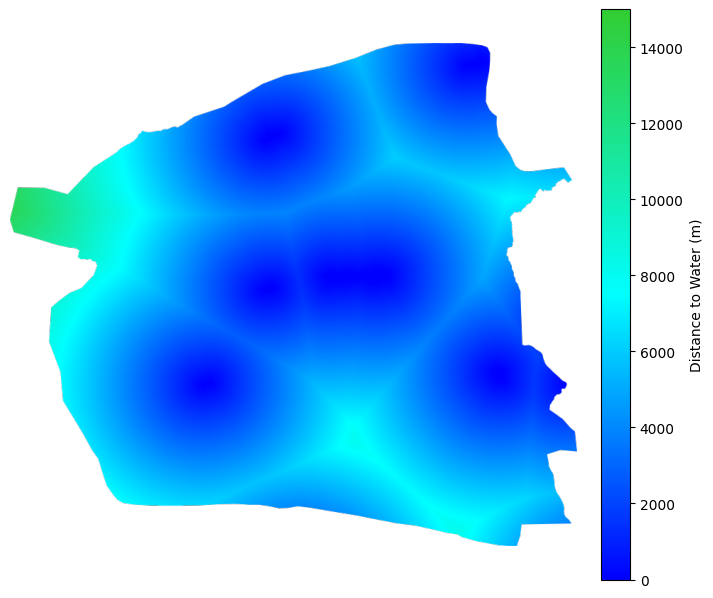

In [30]:
# Must coarsen scale for display purposes (ONLY FOR DISPLAY PURPOSES)
# Need to recompute distance at coarser scale to avoid memory issues when generating thumbnail
# Reason: distance() uses a kernel that can exceed maxPixels limit when 
# applied at 30m resolution over a large area and fastDistanceTransform() 
# caps out the radius somehow, leading to incorrect results for large areas.
# Computing the distance at 60m resolution after building a conservative 60m 
# water mask helps keep things relatively accurate, while avoiding the kernel issue.

# Build a conservative 60 m water mask (preserve small water)
# This avoids "losing" narrow water features when going from 30m -> 60m.
radius_m = 15000
work_scale = 60
proj60 = ee.Projection('EPSG:32630').atScale(work_scale)

# Conservative downscale: any water in the 30m block becomes water at 60m
water60 = (water_mask
           .reduceResolution(reducer=ee.Reducer.max(), maxPixels=1024)
           .reproject(proj60)
           .toByte())

# Compute distance at 60 m (kernel now within limits)
distance_to_water_60 = (water60
    .distance(ee.Kernel.euclidean(radius=radius_m, units='meters'))
    .reproject(proj60)
    .clip(urban_roi)
    .rename('distance_to_water'))

# GitHub-friendly visual
thumb_url = distance_to_water_60.getThumbUrl({
    'min': 0,
    'max': 15000,
    'palette': water_palette,
    'dimensions': 800,
    'region': urban_roi,
    'crs': 'EPSG:4326'
})

# Download the thumbnail PNG
png = requests.get(thumb_url).content
img = PILImage.open(BytesIO(png)).convert("RGBA")

# Build a matplotlib colormap from the EE palette
cmap = LinearSegmentedColormap.from_list("ee_palette", water_palette)
vmin, vmax = 0, 15000

# Plot image + colorbar
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
ax.axis("off")

mappable = plt.cm.ScalarMappable(cmap=cmap)
mappable.set_clim(vmin, vmax)

cbar = plt.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Distance to Water (m)")

plt.show()

### Histogram

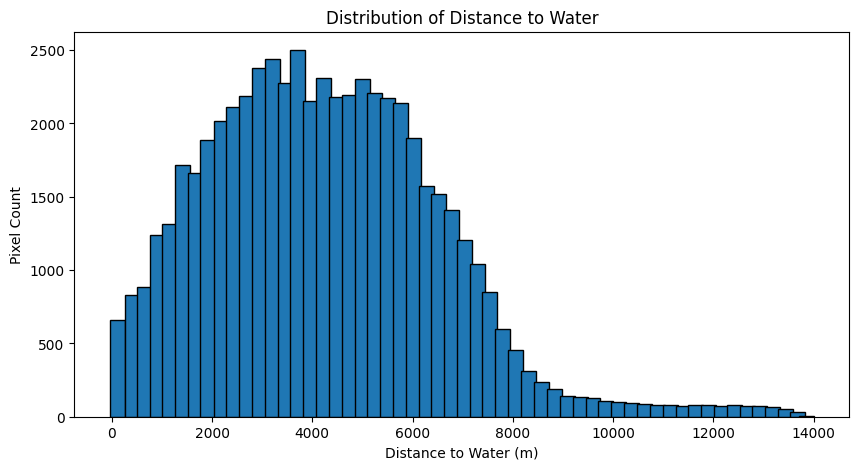

In [31]:
# Histogram of distance distribution
histogram = distance_to_water.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=50),
    geometry=urban_roi,
    scale=100,
    bestEffort=True,
    maxPixels=1e9
).getInfo()

# Plot histogram
hist_data = histogram['distance_to_water']
bucket_means = hist_data['bucketMeans']
counts = hist_data['histogram']

plt.figure(figsize=(10, 5))
plt.bar(bucket_means, counts, width=bucket_means[1]-bucket_means[0], edgecolor='black')
plt.xlabel('Distance to Water (m)')
plt.ylabel('Pixel Count')
plt.title('Distribution of Distance to Water')
plt.show()

This makes sense that we'd have a tail, considering how few and centrally located the reservoirs are. The farther out you go from the city center, the fewer pixels there are at those large distances, but some peripheral areas of the urban boundary can be quite far from any water body.

### Comparison: `distance()` vs `fastDistanceTransform()`

Both methods compute Euclidean distance to the nearest **non-zero** pixel, but use different algorithms:

- **`distance(kernel)`**: Convolution-based approach using an explicit kernel. Returns distance in meters directly. Intuitive but memory-intensive for large radii at fine resolutions (as seen in the thumbnail generation above).
- **`fastDistanceTransform()`**: Efficient multi-pass exact distance transform. Returns squared distance in **pixel** units, which must be converted to meters. More scalable for production pipelines.

**Important**: Because `fastDistanceTransform()` works in pixel units, it is sensitive to GEE's lazy evaluation. GEE evaluates operations at whatever scale the downstream consumer requests (e.g., 100m in `reduceRegion`). If FDT runs at 100m pixels but you multiply by 30 (assuming 30m pixels), all distances will be wrong by a factor of ~3.3x. The fix is to place `.reproject()` **after** `fastDistanceTransform()` — `reproject` forces all upstream computation (including the FDT itself) to happen at the specified scale. Placing it *before* FDT only affects the input, not the FDT computation itself.

In [32]:
# --- Compute distance using fastDistanceTransform for comparison ---
# fastDistanceTransform works in PIXEL units. GEE's lazy evaluation means the
# transform runs at whatever scale the downstream consumer requests (e.g., 100m
# from reduceRegion), not the image's native resolution. Placing .reproject()
# AFTER fastDistanceTransform forces the entire FDT computation to happen at
# 30m pixels, making the multiply(30) conversion correct.
proj30 = ee.Projection('EPSG:32630').atScale(30)

distance_water_squared_fdt = (
    water_mask
    .fastDistanceTransform(
        neighborhood=500,  # Max search in pixels: 500 * 30m = ~15km
        units='pixels',
        metric='squared_euclidean'
    )
    .reproject(proj30)  # Force FDT to compute at 30m pixels
)
distance_to_water_fdt = (
    distance_water_squared_fdt
    .sqrt()
    .multiply(30)  # Convert pixels to meters (30m reprojected resolution)
    .clip(urban_roi)
    .rename('distance_to_water')
)

# Compare summary statistics
reducer = ee.Reducer.minMax().combine(
    reducer2=ee.Reducer.mean(),
    outputPrefix='',
    sharedInputs=True
)
stats_kernel = distance_to_water.reduceRegion(
    reducer=reducer, geometry=urban_roi, scale=100, bestEffort=True
).getInfo()

stats_fdt = distance_to_water_fdt.reduceRegion(
    reducer=reducer, geometry=urban_roi, scale=100, bestEffort=True
).getInfo()

print('=== Distance to Water: Method Comparison ===\n')
print(f"{'Metric':<8} {'distance() (kernel)':>20} {'fastDistanceTransform':>22}")
print('-' * 52)
for metric, label in [('min', 'Min'), ('max', 'Max'), ('mean', 'Mean')]:
    k = f'distance_to_water_{metric}'
    print(f'{label:<8} {stats_kernel[k]:>18.0f} m {stats_fdt[k]:>20.0f} m')


=== Distance to Water: Method Comparison ===

Metric    distance() (kernel)  fastDistanceTransform
----------------------------------------------------
Min                       0 m                    0 m
Max                   13946 m                13591 m
Mean                   4260 m                 4140 m


Pixel-level difference (kernel - fastDistanceTransform):
  Min diff:  -50.00 m
  Max diff:  519.13 m
  Mean diff: 119.06 m
  Std dev:   91.04 m


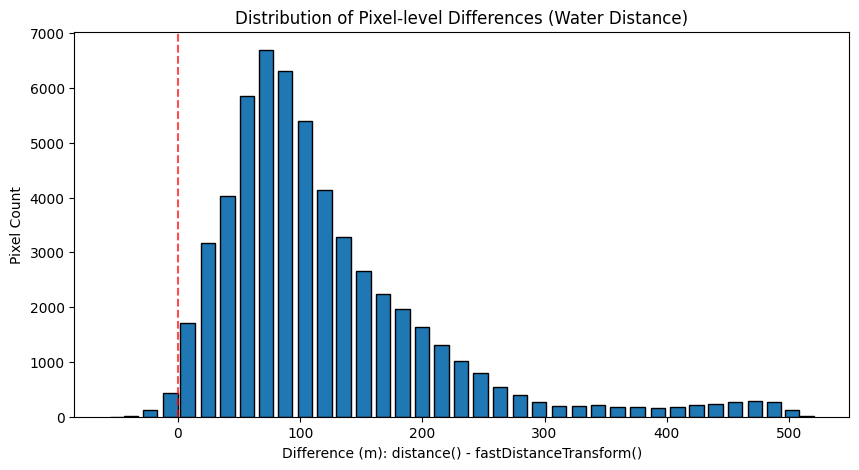

In [33]:
# Pixel-level difference between the two methods
diff_water = distance_to_water.subtract(distance_to_water_fdt).rename('difference')

diff_water_stats = diff_water.reduceRegion(
    reducer=ee.Reducer.minMax().combine(
        ee.Reducer.mean(), sharedInputs=True
    ).combine(
        ee.Reducer.stdDev(), sharedInputs=True
    ),
    geometry=urban_roi,
    scale=100,
    bestEffort=True
).getInfo()

print('Pixel-level difference (kernel - fastDistanceTransform):')
print(f"  Min diff:  {diff_water_stats['difference_min']:.2f} m")
print(f"  Max diff:  {diff_water_stats['difference_max']:.2f} m")
print(f"  Mean diff: {diff_water_stats['difference_mean']:.2f} m")
print(f"  Std dev:   {diff_water_stats['difference_stdDev']:.2f} m")

# Histogram of differences
diff_histogram = diff_water.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=50),
    geometry=urban_roi,
    scale=100,
    bestEffort=True,
    maxPixels=1e9
).getInfo()

hist_data = diff_histogram['difference']
bucket_means = hist_data['bucketMeans']
counts = hist_data['histogram']

plt.figure(figsize=(10, 5))
plt.bar(bucket_means, counts, width=bucket_means[1] - bucket_means[0], edgecolor='black')
plt.xlabel('Difference (m): distance() - fastDistanceTransform()')
plt.ylabel('Pixel Count')
plt.title('Distribution of Pixel-level Differences (Water Distance)')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.show()


The two methods agree closely (mean diff ~119m on a ~4km mean distance, or ~2.8%). The remaining differences are expected: `distance()` evaluates at the `reduceRegion` scale of 100m, while `fastDistanceTransform()` is pinned to 30m via `.reproject()`. At 100m resolution, small water features can be absorbed into non-water pixels, slightly inflating the kernel-based distances. The FDT at 30m better preserves these features, giving marginally shorter (and likely more accurate) distances.

`fastDistanceTransform()` is generally preferred for production pipelines because it avoids creating a large convolution kernel, making it more memory-efficient and scalable. The key gotcha is that it works in **pixel units** — without `.reproject()` placed **after** the FDT call, GEE's lazy evaluation will run the transform at an unexpected scale (e.g., 100m from a downstream `reduceRegion`), making the pixel-to-meter conversion silently wrong.

# Distance to roads

## Using GRIP road data

The Global Roads Inventory Project (GRIP) dataset doesn't quite cover the whole region and is somewhat incomplete in the outskirt areas. Some of the smaller road networks are left out, leaving an incomplete vector dataset for computing distances.

In [21]:
# Load GRIP4 roads for Africa (community dataset)
grip_roads = ee.FeatureCollection('projects/sat-io/open-datasets/GRIP4/Africa')

# Filter to study area
grip_urban_roads = grip_roads.filterBounds(urban_roi)

# Filter for major roads only (highways + primary + secondary)
# GP_RTP: 1 = highway, 2 = primary, 3 = secondary, 4 = tertiary, 5 = local
grip_major_roads = grip_urban_roads.filter(ee.Filter.inList('GP_RTP', [1, 2, 3]))

# Rasterize roads: paint roads onto an empty image
grip_road_raster = ee.Image().paint(grip_major_roads, 1).unmask(0)

# Compute Euclidean distance from each pixel to nearest major road
distance_to_grip_roads = grip_road_raster.distance(
    ee.Kernel.euclidean(radius=15000, units='meters')
).clip(urban_roi).rename('distance_to_roads')

# Calculate summary statistics
stats = distance_to_grip_roads.reduceRegion(
    reducer=ee.Reducer.minMax().combine(
        reducer2=ee.Reducer.mean(),
        sharedInputs=True
    ),
    geometry=urban_roi,
    scale=100,
    bestEffort=True
).getInfo()

print("Distance to Major Roads Statistics (GRIP4):")
print(f"  Min:  {stats['distance_to_roads_min']:.0f} meters")
print(f"  Max:  {stats['distance_to_roads_max']:.0f} meters")
print(f"  Mean: {stats['distance_to_roads_mean']:.0f} meters")

# Visualize
Map = geemap.Map()
Map.setCenter(-1.45, 12.345, 11)
Map.add_basemap('Esri.WorldImagery')

# Show major roads as vectors
Map.addLayer(grip_major_roads, {'color': 'red'}, 'Major Roads (GRIP4)')

# Show distance raster
road_palette = ['green', 'yellow', 'orange', 'red']
road_distance_vis = {'min': 0, 'max': 10000, 'palette': road_palette}
Map.addLayer(distance_to_grip_roads, road_distance_vis, 'Distance to Major Roads (m)')
Map.add_colorbar(vis_params=road_distance_vis, label='Distance to Major Roads (m)')

# Urban boundary
Map.addLayer(urban_roi, {'color': 'black'}, 'Ouagadougou Boundary', False)

Map

Distance to Major Roads Statistics (GRIP4):
  Min:  0 meters
  Max:  8106 meters
  Mean: 2059 meters


Map(center=[12.345, -1.45], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright…

## Using OSM

The Open Street Map (OSM) vector dataset from BBBike (https://extract.bbbike.org/) is more complete. This is also the same methodological approach for data acquisition that Hoang et al. used. 

However, there were some strange artifacts that needed to be manually removed. These were primarily extremely long roads that did not correspond to any actual road or highway. They were removed by excluding roads with a length greater than 20,000 meters.

### Cleaning the OSM road data

In [34]:
# Load roads shapefile
roads_gdf = gpd.read_file('../data/raw/osm-roads/planet_-1.795,12.14_-1.265,12.588-shp/ouaga-roads-shape/roads.shp')

# Check the current CRS
print(f"Original CRS: {roads_gdf.crs}")

# Reproject to UTM Zone 30N (appropriate for Burkina Faso)
# This converts from lat/lon degrees to meters
roads_utm = roads_gdf.to_crs('EPSG:32630')

# Calculate length in actual meters
roads_utm['length_m'] = roads_utm.geometry.length

# Check the new length distribution
print("\nRoad length statistics (in meters):")
print(roads_utm['length_m'].describe())
print(f"\nMaximum length: {roads_utm['length_m'].max():.2f} meters")

# Filter out the problematic long segments (> 20,000 meters)
max_reasonable_length = 20000
roads_clean = roads_utm[roads_utm['length_m'] <= max_reasonable_length].copy()
roads_long = roads_utm[roads_utm['length_m'] > max_reasonable_length].copy()

print(f"\nOriginal segments: {len(roads_gdf)}")
print(f"Cleaned segments: {len(roads_clean)}")
print(f"Removed: {len(roads_gdf) - len(roads_clean)} segments")

# Reproject back to WGS84 for saving
roads_clean = roads_clean.to_crs('EPSG:4326')
roads_long = roads_long.to_crs('EPSG:4326')

# Save the cleaned version
output_path = '../data/raw/osm-roads/planet_-1.795,12.14_-1.265,12.588-shp/ouaga-roads-shape/roads_cleaned.shp'
roads_clean.to_file(output_path)
print(f"\nSaved cleaned roads to: {output_path}")

Original CRS: EPSG:4326

Road length statistics (in meters):
count    8.253000e+04
mean     3.359220e+02
std      8.488625e+03
min      5.448531e-01
25%      7.572554e+01
50%      1.472672e+02
75%      2.927661e+02
max      1.768435e+06
Name: length_m, dtype: float64

Maximum length: 1768434.60 meters

Original segments: 82530
Cleaned segments: 82503
Removed: 27 segments

Saved cleaned roads to: ../data/raw/osm-roads/planet_-1.795,12.14_-1.265,12.588-shp/ouaga-roads-shape/roads_cleaned.shp


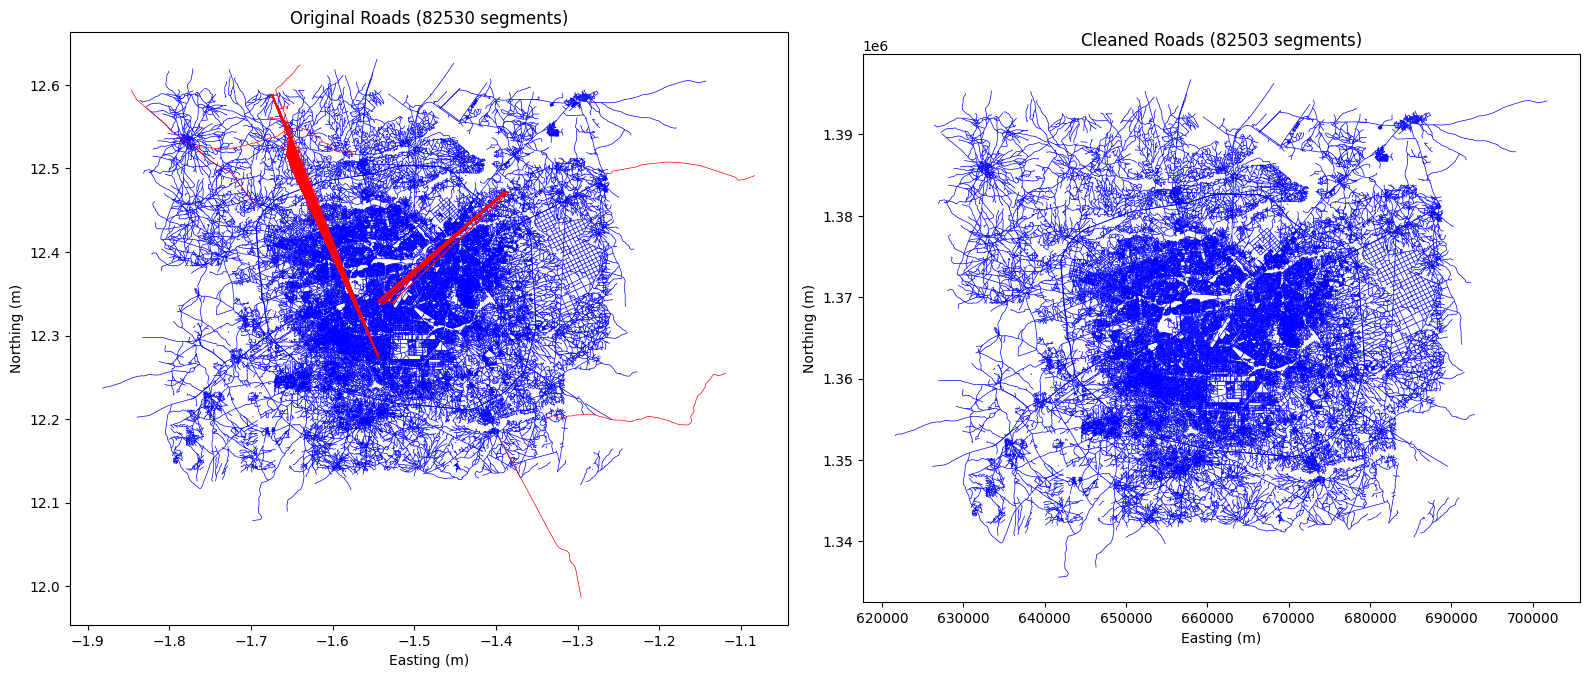


Removed segments details:
           length_m                          name
78599  1.768435e+06                          None
4960   1.656757e+06                          None
13554  1.553743e+05                          None
4699   4.485338e+04                          None
2580   4.483817e+04                          None
1946   4.469567e+04                          None
2584   4.445431e+04                          None
15860  4.430383e+04                          None
2593   4.425080e+04                          None
2577   4.424083e+04                          None
15830  4.414557e+04                          None
15820  4.327607e+04  Boulevard Ratag Pima (16.02)
78081  3.756984e+04                          None
77120  3.612692e+04                          None
77116  3.609980e+04                          None
78120  3.268216e+04                          None
77583  3.192398e+04                          None
77575  3.082833e+04                          None
11563  3.014932e+04    

In [23]:
# Comparison visualization: original vs cleaned roads
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Original roads with artifacts highlighted in red
roads_clean.plot(ax=ax1, color='blue', linewidth=0.5)
roads_long.plot(ax=ax1, color='red', linewidth=0.5)
ax1.set_title(f'Original Roads ({len(roads_utm)} segments)')
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')

# Cleaned roads
roads_clean.to_crs('EPSG:32630').plot(ax=ax2, color='blue', linewidth=0.5)
ax2.set_title(f'Cleaned Roads ({len(roads_clean)} segments)')
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Northing (m)')

plt.tight_layout()
plt.show()

# Show what we removed
if len(roads_long) > 0:
    print("\nRemoved segments details:")
    print(roads_long[['length_m', 'name']].sort_values('length_m', ascending=False))

### Computing distance to roads using cleaned OSM data

The cleaned OSM roads were uploaded to Google Earth Engine as an asset for distance computation.

In [35]:
# Load uploaded roads asset
roads_fc = ee.FeatureCollection('projects/ee-helyne/assets/Ouaga_roads')

# Filter to urban_roi
urban_roads_fc = roads_fc.filterBounds(urban_roi)

# Check the data
print(f"Total road features: {roads_fc.size().getInfo()}")
print(f"Roads in urban_roi: {urban_roads_fc.size().getInfo()}")

# Preview the attribute columns
print(f"Columns: {urban_roads_fc.first().propertyNames().getInfo()}")

# Rasterize roads to binary mask
road_raster = ee.Image().paint(urban_roads_fc, 1).unmask(0)

# Calculate Euclidean distance to nearest road
distance_to_roads = road_raster.distance(
    ee.Kernel.euclidean(radius=10000, units='meters')
).clip(urban_roi).rename('distance_to_roads')

# Calculate statistics
stats = distance_to_roads.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=urban_roi,
    scale=100,
    bestEffort=True
).getInfo()

print("\nDistance to Roads Statistics (OSM):")
print(f"  Min:  {stats['distance_to_roads_min']:.0f} meters")
print(f"  Max:  {stats['distance_to_roads_max']:.0f} meters")
print(f"  Mean: {stats['distance_to_roads_mean']:.0f} meters")

# Visualize
Map = geemap.Map()
Map.setCenter(-1.45, 12.345, 11)
Map.add_basemap('Esri.WorldImagery')

# Show roads as vectors (may be slow if many features)
Map.addLayer(urban_roads_fc.style(color='yellow', width=1), {}, 'OSM Roads', False)

# Show distance raster
road_palette = ['green', 'yellow', 'orange', 'red']
road_distance_vis = {'min': 0, 'max': 3000, 'palette': road_palette}
Map.addLayer(distance_to_roads, road_distance_vis, 'Distance to Roads (m)')
Map.add_colorbar(vis_params=road_distance_vis, label='Distance to Roads (m)')

Map

Total road features: 82503
Roads in urban_roi: 47265
Columns: ['osm_id', 'ref', 'name', 'maxspeed', 'bridge', 'type', 'oneway', 'system:index', 'length_m']

Distance to Roads Statistics (OSM):
  Min:  0 meters
  Max:  640 meters
  Mean: 26 meters


Map(center=[12.345, -1.45], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright…

### Comparison: `distance()` vs `fastDistanceTransform()` for roads

Same comparison as above, but for the road distance. Since `ee.Image().paint()` creates a raster without a meaningful default projection, `.reproject()` is especially important here — it both sets the CRS and pins the pixel size for correct meter conversion.

In [36]:
# For fastDistanceTransform on a painted road raster:
# 1. ee.Image().paint() has no meaningful default projection, so we set one
# 2. .reproject() AFTER FDT forces the transform to compute at 30m pixels
road_raster_proj = (
    ee.Image()
    .paint(urban_roads_fc, 1)
    .unmask(0)
    .setDefaultProjection(crs='EPSG:32630', scale=30)
)

# Compute distance using fastDistanceTransform
distance_roads_squared_fdt = (
    road_raster_proj
    .fastDistanceTransform(
        neighborhood=500,  # 500 * 30m = ~15km max
        units='pixels',
        metric='squared_euclidean'
    )
    .reproject(crs='EPSG:32630', scale=30)  # Force FDT to compute at 30m
)
distance_to_roads_fdt = (
    distance_roads_squared_fdt
    .sqrt()
    .multiply(30)  # Convert pixels to meters (30m reprojected resolution)
    .clip(urban_roi)
    .rename('distance_to_roads')
)

# Compare statistics
reducer = ee.Reducer.minMax().combine(
    reducer2=ee.Reducer.mean(),
    outputPrefix='',
    sharedInputs=True
)
stats_roads_kernel = distance_to_roads.reduceRegion(
    reducer=reducer, geometry=urban_roi, scale=100, bestEffort=True
).getInfo()

stats_roads_fdt = distance_to_roads_fdt.reduceRegion(
    reducer=reducer, geometry=urban_roi, scale=100, bestEffort=True
).getInfo()

print('=== Distance to Roads (OSM): Method Comparison ===\n')
print(f"{'Metric':<8} {'distance() (kernel)':>20} {'fastDistanceTransform':>22}")
print('-' * 52)
for metric, label in [('min', 'Min'), ('max', 'Max'), ('mean', 'Mean')]:
    k = f'distance_to_roads_{metric}'
    print(f'{label:<8} {stats_roads_kernel[k]:>18.0f} m {stats_roads_fdt[k]:>20.0f} m')

# Pixel-level difference
diff_roads = distance_to_roads.subtract(distance_to_roads_fdt).rename('difference')

diff_roads_stats = diff_roads.reduceRegion(
    reducer=ee.Reducer.minMax().combine(
        ee.Reducer.mean(), sharedInputs=True
    ).combine(
        ee.Reducer.stdDev(), sharedInputs=True
    ),
    geometry=urban_roi,
    scale=100,
    bestEffort=True
).getInfo()

print(f"\nPixel-level difference (kernel - fastDistanceTransform):")
print(f"  Min diff:  {diff_roads_stats['difference_min']:.2f} m")
print(f"  Max diff:  {diff_roads_stats['difference_max']:.2f} m")
print(f"  Mean diff: {diff_roads_stats['difference_mean']:.2f} m")
print(f"  Std dev:   {diff_roads_stats['difference_stdDev']:.2f} m")


=== Distance to Roads (OSM): Method Comparison ===

Metric    distance() (kernel)  fastDistanceTransform
----------------------------------------------------
Min                       0 m                    0 m
Max                     640 m                  607 m
Mean                     26 m                   35 m

Pixel-level difference (kernel - fastDistanceTransform):
  Min diff:  -94.87 m
  Max diff:  100.00 m
  Mean diff: -9.81 m
  Std dev:   24.28 m


The road results show a small mean difference of ~10m (std dev ~24m), with a slight negative bias — the FDT at 30m gives marginally larger distances. This is likely because roads are thin linear features: at 100m resolution, a road pixel gets "expanded" to cover more area, so `distance()` slightly underestimates distance to roads. At 30m, road lines are more precisely rasterized.

**Summary**: Both methods measure the same thing (Euclidean distance to nearest non-zero pixel) and produce consistent results once correctly configured (~2-5% agreement). `fastDistanceTransform()` is more suitable for a production ML pipeline because:
1. It avoids large kernel memory issues that `distance()` runs into at fine resolutions over large areas
2. It scales better to larger regions without requiring manual resolution workarounds
3. It operates at finer resolution (30m), better preserving small features like narrow water bodies and thin road lines

The key gotcha with `fastDistanceTransform()`:
- It works in **pixel units** and GEE evaluates it lazily at whatever downstream scale is requested. You must place `.reproject()` **after** `fastDistanceTransform()` to pin the computation scale. Placing it before only affects the input, not the FDT itself. For painted rasters (like roads), also use `.setDefaultProjection()` on the input so GEE knows the intended pixel size.